## Considerations

Flatten a Res1D object into a "simple" generic network representation that can be specified solely in terms of nodes and edges.

(The following are based on `Res1D` format and I assume they apply to other network formats, like EPANET)

We want to create a Generic Network Coordinates (GNC) that modelskill can interpret.

- A `Res1D` file encapsulates a complex structure with multiple layers/dimensions (quantities, reaches, nodes, catchments). This structure is arbitrary and specific to MIKE1D.
- When using `modelskill`, a user is interested in a small subset of all the information present in a `Res1D` file.
    - The number of measured locations might significantly vary: distribution systems might work with hundreds of sensors, whereas collection systems typically work with only a few.
- In reality, most of the measurements will be taken near the nodes.
- Users are familiar with the nomenclature of a `Res1D` object and some of its idiosyncracies (e.g. gridpoints might "overlap" with nodes).
    - They will need to provide additional information to solve potential conflicts and they must be able to navigate `MIKE1D` to specify network locations.
- In case they want to compare a measure that is not in a node location, a _dummy node_ will be inserted.
- `modelskill` will accept coordinates based on GNC, `mikeio1d` will offer functionality to map network formats (`Res1D`, `EPANET`, ...) to GNC.
- In GNC object, every node will have an ID and a single associated timeseries of the quantity


In [1]:
import networkx as nx
import matplotlib.pyplot as plt

from mikeio1d import Res1D
from mikeio1d.result_network.format_mapper import Res1DMapper

res = Res1D("../tests/testdata/network.res1d")
res

<mikeio1d.Res1D>

## Workflow

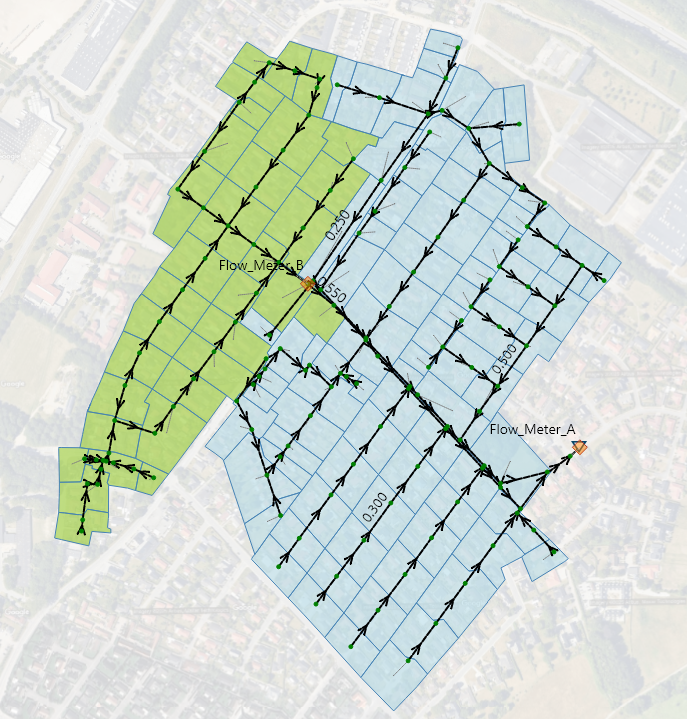

In [2]:
priority = {
    "edges": ["22l1", "105l1", "110l1"],
    "inclusions": [{"edge": "100l1", "distance": 23.841}]
    }

mapper = Res1DMapper(res, priority=priority)

In [3]:
# - The simplified network is specified solely by nodes and edges
# - Nodes have unique int ids
# - Every node contains a dataframe with the relevant quantities (the column names have been simplified)
new_id = 4
mapper._g0.nodes.get(new_id)
# - You can get a node id in the simplified network by passing the original element from the Res1D file 
res1d_element = res.nodes["100"]
mapper.get_node_id(res1d_element)
# The data can be accessed as a dataframe
mapper.as_df.head()

node,node-100,node-99,node-101,node-102,node-82,node-103,node-23,node-104,node-28,gridpoint-105l1-0.0,...,node-90,node-91,node-92,node-94,node-95,node-96,node-97,node-98,node-Weir Outlet:119w1,gridpoint-100l1-23.841
quantity,WaterLevel,WaterLevel,WaterLevel,WaterLevel,WaterLevel,WaterLevel,WaterLevel,WaterLevel,WaterLevel,WaterLevel,...,WaterLevel,WaterLevel,WaterLevel,WaterLevel,WaterLevel,WaterLevel,WaterLevel,WaterLevel,WaterLevel,Discharge
1994-08-07 16:35:00.000,195.441498,194.661499,195.931503,193.550003,193.550003,195.801498,195.703003,197.072006,196.962006,197.351501,...,196.272995,196.322006,196.401993,196.851501,196.891495,196.601501,194.511505,194.581497,193.779999,0.000006
1994-08-07 16:36:01.870,195.441605,194.661621,195.931595,193.550140,193.550064,195.801498,195.703171,197.072006,196.962051,197.351501,...,196.272995,196.322037,196.402023,196.851501,196.891495,196.601501,194.511841,194.581497,188.479996,0.000006
1994-08-07 16:37:07.560,195.441620,194.661728,195.931625,193.550232,193.550156,195.801498,195.703400,197.072006,196.962082,197.351501,...,196.272995,196.322052,196.402039,196.851501,196.891495,196.601501,194.511795,194.581497,188.479996,0.000006
1994-08-07 16:38:55.828,195.441605,194.661926,195.931656,193.550369,193.550308,195.801498,195.703690,197.072006,196.962112,197.351501,...,196.272995,196.322067,196.402069,196.851501,196.891495,196.601501,194.511581,194.581497,188.479996,0.000006
1994-08-07 16:39:55.828,195.441605,194.661972,195.931656,193.550430,193.550369,195.801498,195.703827,197.072006,196.962128,197.351501,...,196.272995,196.322067,196.402069,196.851501,196.891495,196.601501,194.511505,194.581497,188.479996,0.000006


In [4]:
mapper.get_node_id(res1d_element)

'node-100'

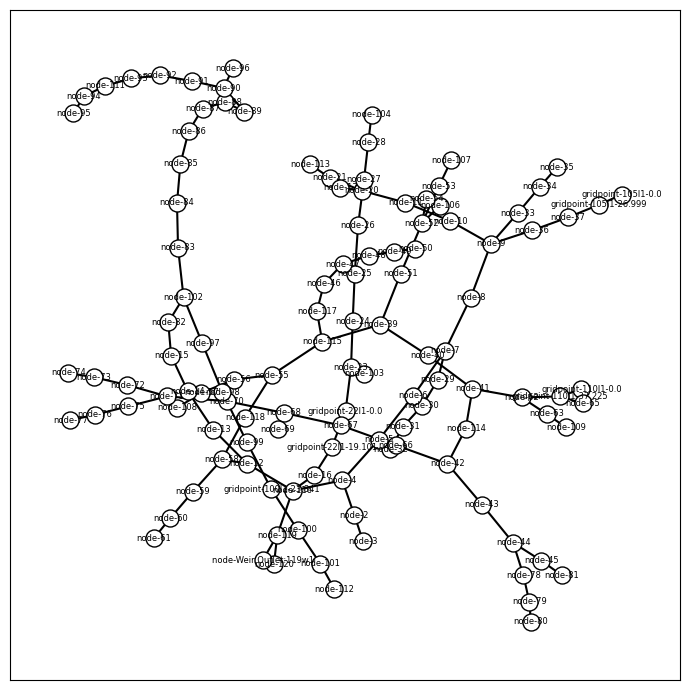

In [5]:
options = {
    "font_size": 6,
    "node_size": 150,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1.5,
}
fig, ax = plt.subplots(1, 1, sharey=True, layout="tight", figsize=(7, 7)) 
nx.draw_networkx(mapper._g0, ax=ax, **options)

plt.show()